In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN 

In [2]:
# load data
df = pd.read_csv("../data/raw_data/online_retail.csv")

In [3]:
# first view of the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# shape of the data
df.shape

(541909, 8)

In [5]:
# info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# descriptive analysis
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
# check missing CustomerID
print(df['CustomerID'].isnull().sum()) # 135080 missing values in CustomerID col.

# check missing InvoiceNo
print(df['InvoiceNo'].isnull().sum()) # 0 missing values in InvoiceNo col.

135080
0


In [8]:
# check negative quantities and prices and sum it up
neg_quantities = df[df['Quantity'] < 0]
print(len(neg_quantities)) # 10624 neg quantities

neg_zero_prices = df[df['UnitPrice'] <= 0]
print(len(neg_zero_prices)) # 2517 neg and zero prices collectively

10624
2517


In [9]:
# check number of cancelled invoices
cancelled_invoices = df[df['InvoiceNo'].str.startswith('C')]
print(len(cancelled_invoices)) # 9288 cancelled invoices

9288


In [10]:
# remove all the rows having missing CustomerID, negative quantity, and zero price, and cancelled_invoices

# Remove missing IDs immediately
df = df.dropna(subset=['CustomerID'])

# Combined filter for performance and logic
# Keeps only positive quantity, positive price, and non-cancelled invoices
df = df[
    (df['Quantity'] > 0) & 
    (df['UnitPrice'] > 0) & 
    (~df['InvoiceNo'].str.startswith('C'))
]

# Final polish
df = df.drop_duplicates()

display(df.shape)

(392692, 8)

In [11]:
# As the 'InvoiceDate' is of object type, we need to convert it into Date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
print(df['InvoiceDate'].dtype)

datetime64[ns]


In [12]:
# let's feature engineer the data by adding 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

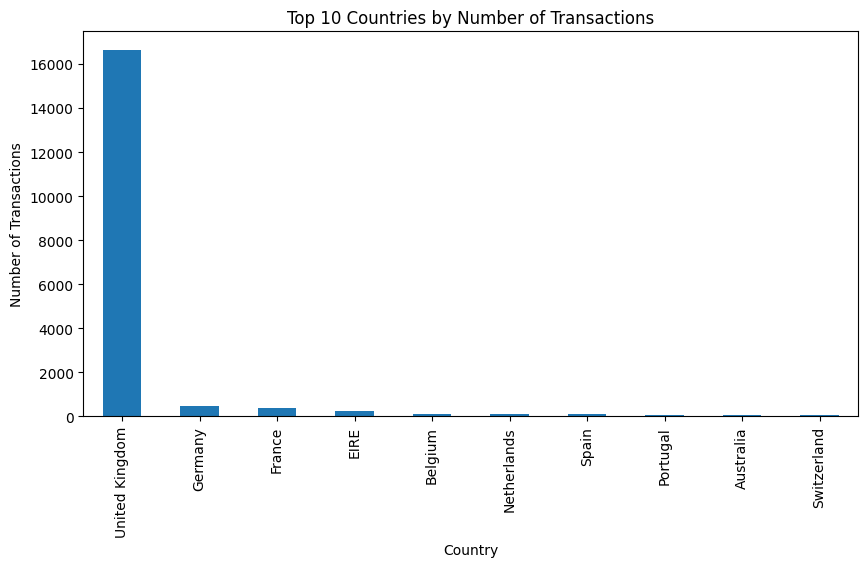

In [13]:
# analyze the transaction volume by country
country_txn = (
    df.groupby('Country')['InvoiceNo']
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
country_txn.plot(kind='bar')
plt.title('Top 10 Countries by Number of Transactions')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.show()


### TODO: write the insights of above visualization

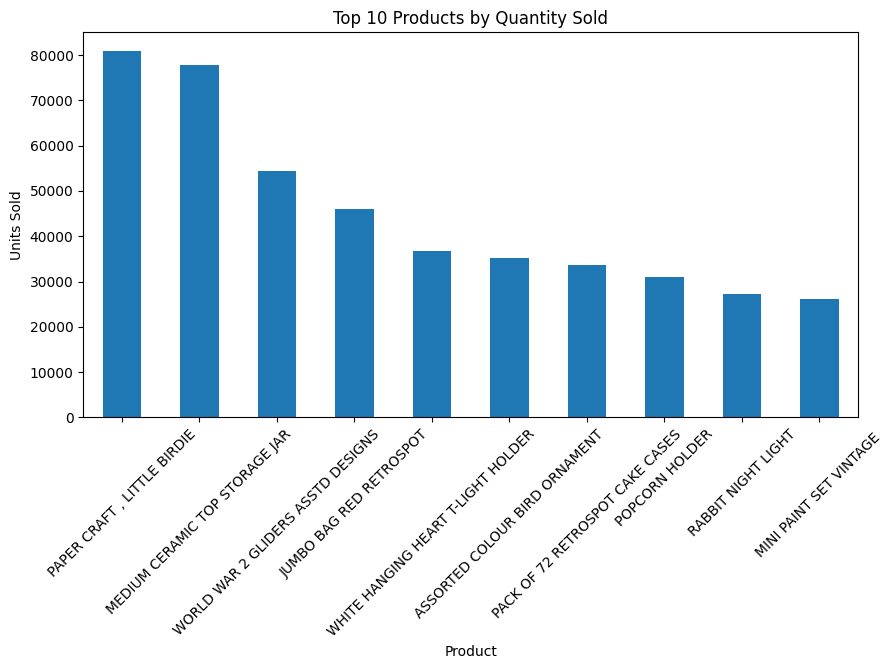

In [14]:
# analyze the top selling products
top_qty_products = (
    df.groupby('Description')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
top_qty_products.plot(kind='bar')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Product')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.show()


### As we have seen above, some products doesn't have any description.

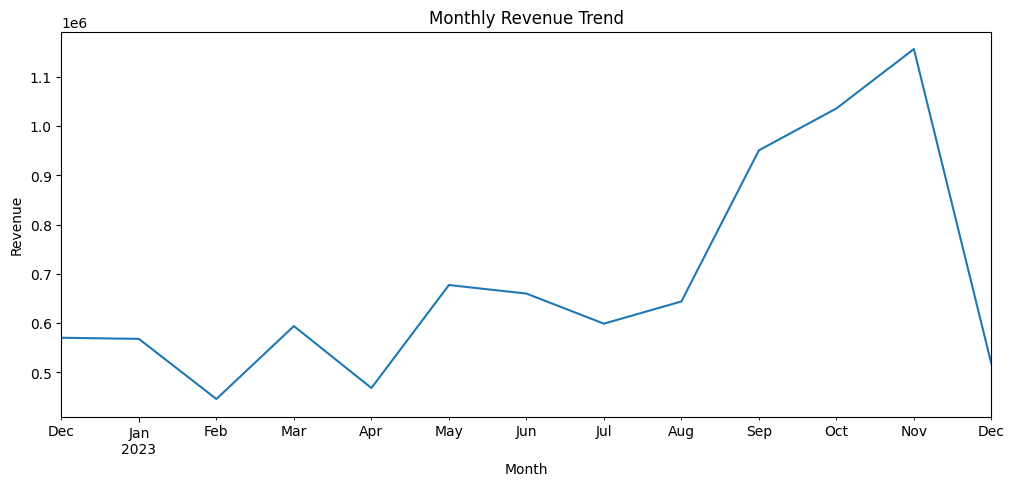

In [15]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')

monthly_revenue = (
    df.groupby('Month')['TotalPrice']
    .sum()
)

plt.figure(figsize=(12,5))
monthly_revenue.plot()
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()


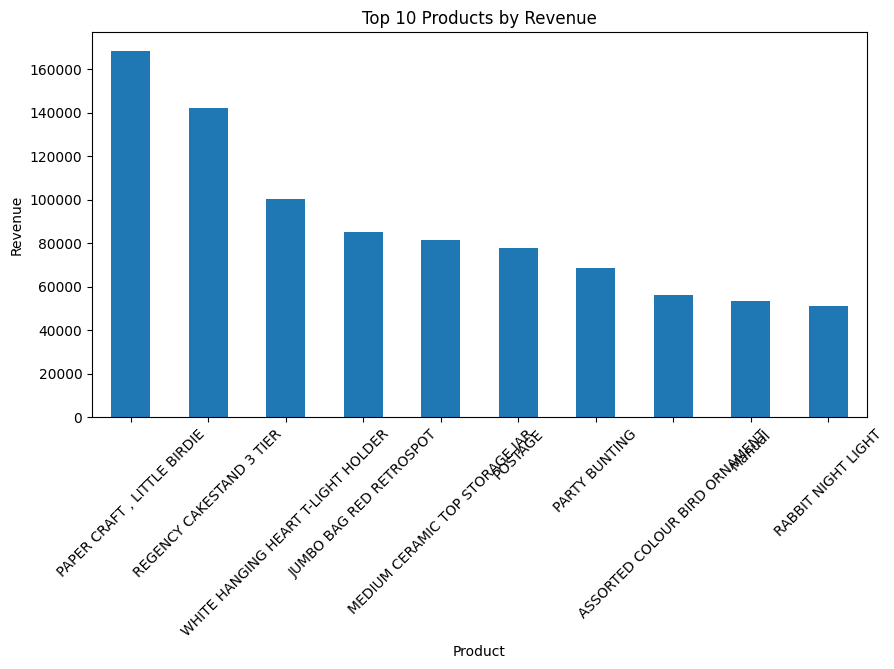

In [16]:
# check top revenue products
top_rev_products = (
    df.groupby('Description')['TotalPrice']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
top_rev_products.plot(kind='bar')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Product')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()


In [17]:
display(df['TotalPrice'])

0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
541904    10.20
541905    12.60
541906    16.60
541907    16.60
541908    14.85
Name: TotalPrice, Length: 392692, dtype: float64

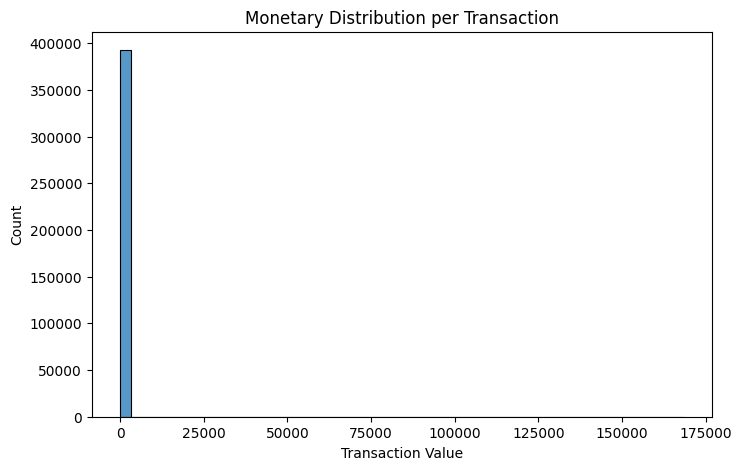

In [18]:
# monetary distribution -> per transaction
plt.figure(figsize=(8,5))
sns.histplot(df['TotalPrice'], bins=50)
plt.title('Monetary Distribution per Transaction')
plt.xlabel('Transaction Value')
plt.show()


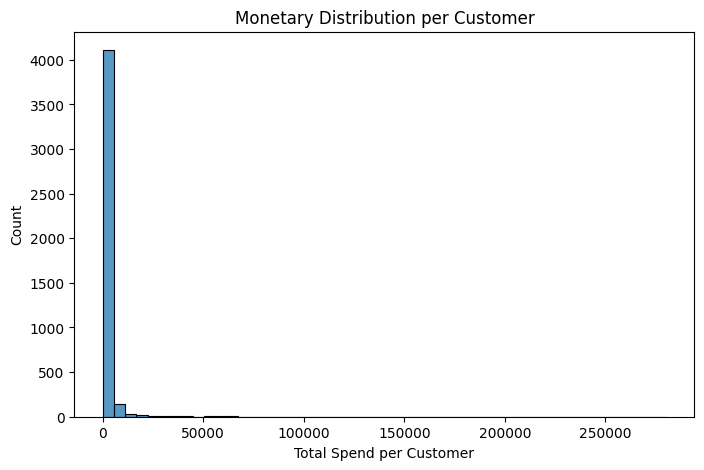

In [19]:
# monetary distribution -> per customer
customer_monetary = df.groupby('CustomerID')['TotalPrice'].sum()

plt.figure(figsize=(8,5))
sns.histplot(customer_monetary, bins=50)
plt.title('Monetary Distribution per Customer')
plt.xlabel('Total Spend per Customer')
plt.show()


In [20]:
# RFM distributions
# choose a ref date 
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1) # why add 1day => customers who bought on the last day get Recency = 1, not 0.

# compute RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

# rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2048.688081
std,1721.808492,100.014169,7.697998,8985.230220
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,306.482500
50%,15299.500000,51.000000,2.000000,668.570000
75%,16778.750000,142.000000,5.000000,1660.597500
max,18287.000000,374.000000,209.000000,280206.020000


In [21]:
# RFM must be scaled -> for kmeans it is mandatory
scaler =  StandardScaler()

rfm_scaled = scaler.fit_transform(
    rfm[['Recency', 'Frequency', 'Monetary']]
)


In [22]:
# Elbow curve for cluster selection -> kmeans
inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)


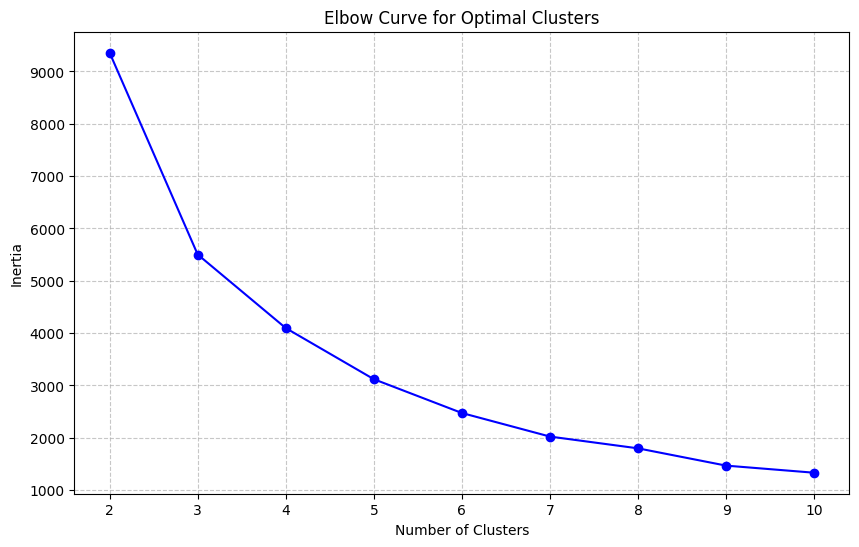

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o', linestyle='-', color='b')
plt.title('Elbow Curve for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

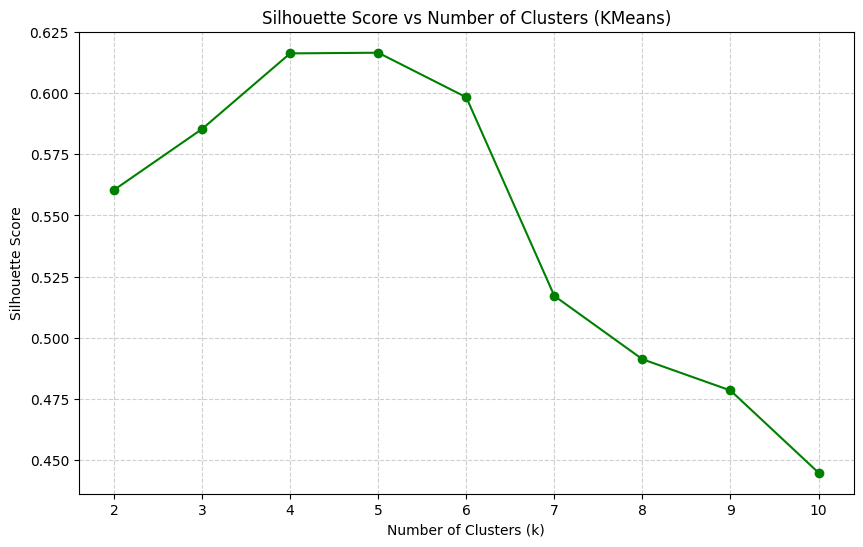

In [24]:
# silhoutte score -> kmeans
silhouette_scores = []

K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(list(K), silhouette_scores, marker='o', linestyle='-', color='g') # Using green to distinguish from Inertia

plt.title('Silhouette Score vs Number of Clusters (KMeans)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

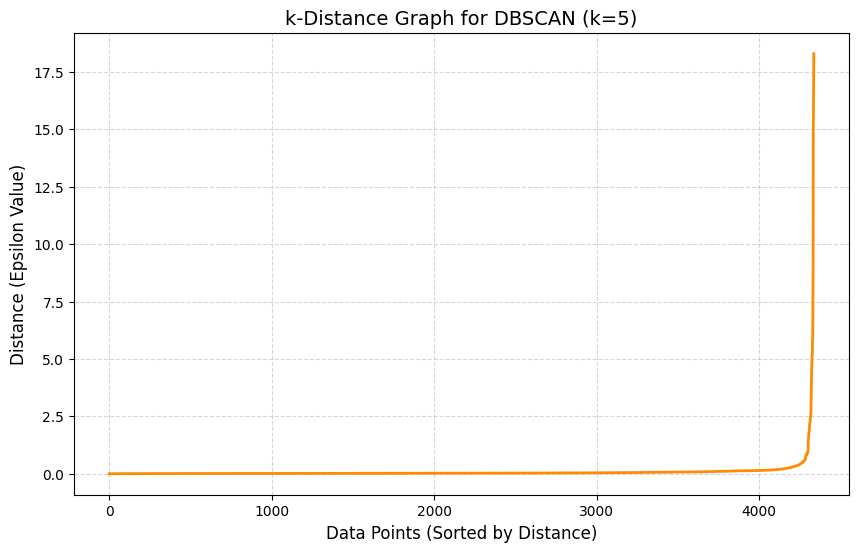

In [25]:
# DBSCAN
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)

sorted_distances = np.sort(distances[:, 4])

plt.figure(figsize=(10, 6))
plt.plot(sorted_distances, color='darkorange', linewidth=2)
plt.title('k-Distance Graph for DBSCAN (k=5)', fontsize=14)
plt.xlabel('Data Points (Sorted by Distance)', fontsize=12)
plt.ylabel('Distance (Epsilon Value)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [26]:
# run DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=5)
db_labels = dbscan.fit_predict(rfm_scaled)

rfm['DBSCAN_Cluster'] = db_labels

rfm['DBSCAN_Cluster'].value_counts()

DBSCAN_Cluster
 0    4292
-1      46
Name: count, dtype: int64

### DBSCAN Clustering Result

DBSCAN was applied to the scaled RFM features to explore density-based customer segmentation.  
The algorithm identified a single dominant cluster containing most customers, with a small number of points labeled as noise (outliers).

This indicates that the RFM data does not exhibit clear density-separated groups, which is expected since customer behavior varies continuously rather than forming compact density clusters. As a result, DBSCAN is not well-suited for this segmentation task.

Therefore, KMeans clustering was selected as the primary approach, as it better captures centroid-based customer groupings and produces more interpretable segments.


In [27]:
# fit final kmeans
k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [28]:
# cluster profile
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'CustomerCount'})

cluster_profile


,Recency,Frequency,Monetary,CustomerCount
Cluster,,,,
0,43.702685,3.682711,1353.625312,3054
1,248.075914,1.552015,478.848773,1067
2,7.384615,82.538462,127187.959231,13
3,15.500000,22.333333,12690.500392,204


In [29]:
# Rank Clusters to Decide Labels
cluster_profile_ranked = cluster_profile.copy()

cluster_profile_ranked['Recency_rank'] = cluster_profile['Recency'].rank(ascending=True) - 1
cluster_profile_ranked['Frequency_rank'] = cluster_profile['Frequency'].rank(ascending=False) - 1
cluster_profile_ranked['Monetary_rank'] = cluster_profile['Monetary'].rank(ascending=False) - 1

cluster_profile_ranked


,Recency,Frequency,Monetary,CustomerCount,Recency_rank,Frequency_rank,Monetary_rank
Cluster,,,,,,,
0,43.702685,3.682711,1353.625312,3054,2.0,2.0,2.0
1,248.075914,1.552015,478.848773,1067,3.0,3.0,3.0
2,7.384615,82.538462,127187.959231,13,0.0,0.0,0.0
3,15.500000,22.333333,12690.500392,204,1.0,1.0,1.0


In [30]:
# assign labels
cluster_labels = {
    0: "High-Value",
    1: "Regular",
    2: "Occasional",
    3: "At-Risk"
}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)


### Cluster Labeling Based on RFM Analysis

Customer clusters were labeled by interpreting the average Recency, Frequency, and Monetary values of each cluster. Lower recency values indicate more recent purchases, while higher frequency and monetary values represent more frequent and higher spending behavior.

Based on these characteristics, clusters were categorized into:
- **High-Value**: Recent, frequent customers with high spending
- **Regular**: Consistent customers with moderate purchase frequency and spending
- **Occasional**: Infrequent customers with low spending and older purchase history
- **At-Risk**: Customers who have not purchased recently and show low engagement

These labeled segments provide actionable insights for targeted marketing and personalized recommendation strategies.


In [31]:
from sklearn.metrics.pairwise import cosine_similarity

item_matrix = df.pivot_table(
    index='CustomerID',
    columns='Description',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)


In [32]:
# pick top selling products
top_products = (
    df.groupby('Description')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .index
)

item_matrix_small = item_matrix[top_products]


In [33]:
# item-item similarity
item_similarity = cosine_similarity(item_matrix_small.T)

item_similarity_df = pd.DataFrame(
    item_similarity,
    index=top_products,
    columns=top_products
)


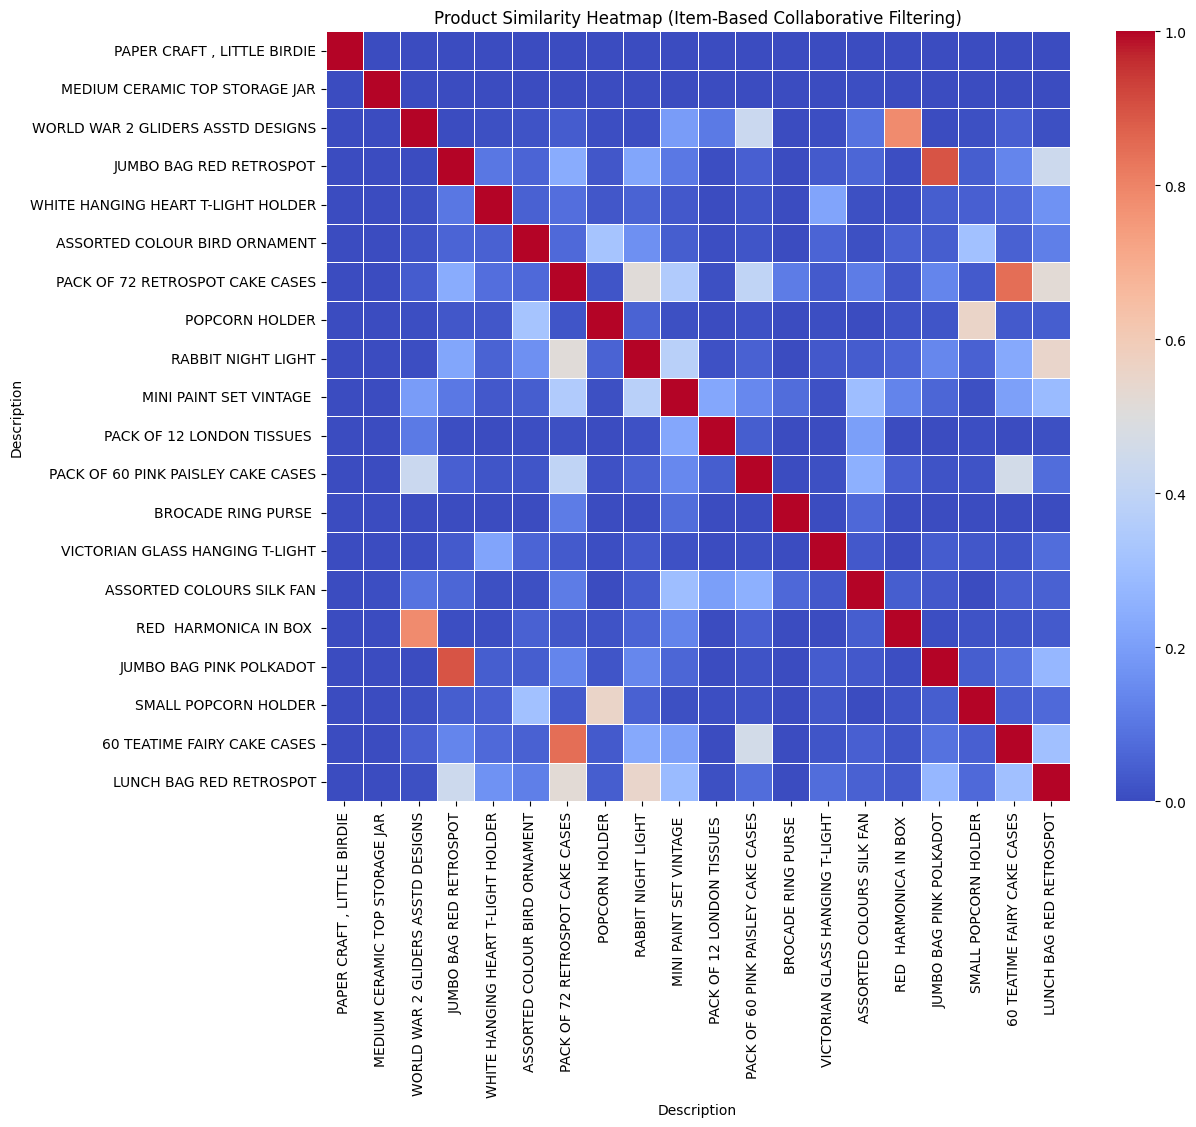

In [34]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    item_similarity_df,
    cmap='coolwarm',
    linewidths=0.5
)
plt.title("Product Similarity Heatmap (Item-Based Collaborative Filtering)")
plt.show()

### Product Similarity Heatmap

An item-based collaborative filtering approach was implemented by constructing a customer–product purchase matrix and computing cosine similarity between products. The heatmap visualizes similarity scores among the top-selling products, where higher values indicate stronger co-purchase relationships. This similarity matrix forms the basis for recommending related products to customers.


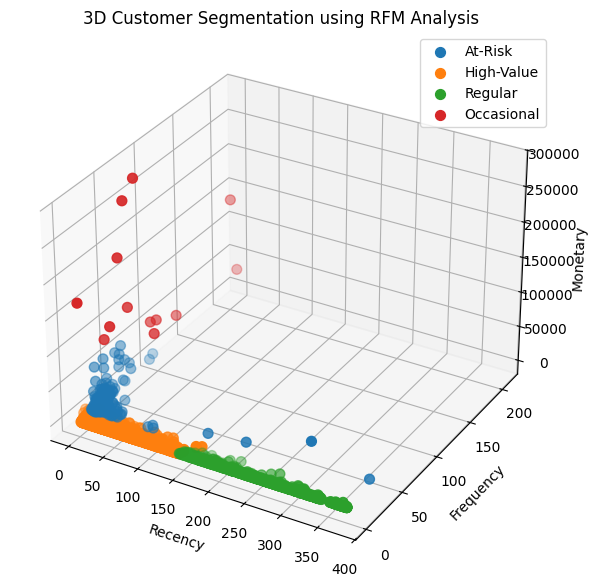

In [35]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111, projection='3d')

for segment in rfm['Segment'].unique():
    subset = rfm[rfm['Segment'] == segment]
    ax.scatter(
        subset['Recency'],
        subset['Frequency'],
        subset['Monetary'],
        label=segment,
        s=50
    )

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Customer Segmentation using RFM Analysis')
ax.legend()
plt.show()


In [36]:
# save the df before visualization
df.to_csv("../data/cleaned_data/cleaned_data.csv", index=False)

In [37]:
import joblib

joblib.dump(kmeans, "../models/kmeans_model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")
joblib.dump(cluster_labels, "../models/cluster_labels.pkl")
joblib.dump(item_similarity_df, "../models/item_similarity.pkl")

['../models/item_similarity.pkl']